<a href="https://www.kaggle.com/code/sayedshaun/melanoma-cancer-prediction-pytorch?scriptVersionId=167458713" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn, Tensor
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchsummary import summary
from torchvision.datasets import ImageFolder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Loading

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
raw_dataset = ImageFolder("/kaggle/input/melanoma-cancer-dataset/train", transform=transform)

class CustomDataset(Dataset):
    def __init__(self, data) -> None:
        super(CustomDataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        return x, y
    
dataset = CustomDataset(raw_dataset)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
x, y = next(iter(dataloader))
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [4]:
y

tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1])

### Model Architecture

In [5]:
class MyCNN(nn.Module):
    def __init__(self, hidden_size:int, kernel_size:int)->None:
        super(MyCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, hidden_size, kernel_size),
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size),
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size),
            nn.MaxPool2d(kernel_size, kernel_size)
        )
        self.linear = nn.Linear(hidden_size * 7 * 7, hidden_size)
        self.classification = nn.Linear(hidden_size, 2)
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, image_tensor:Tensor)->Tensor:
        x = self.conv_block(image_tensor)
        x = self.flatten(x)
        x = self.linear(self.relu(x))
        x = self.dropout(x)
        x = self.classification(x)
        return x
    
model = MyCNN(hidden_size=256, kernel_size=3).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 222, 222]           7,168
         MaxPool2d-2          [-1, 256, 74, 74]               0
            Conv2d-3          [-1, 256, 72, 72]         590,080
         MaxPool2d-4          [-1, 256, 24, 24]               0
            Conv2d-5          [-1, 256, 22, 22]         590,080
         MaxPool2d-6            [-1, 256, 7, 7]               0
           Flatten-7                [-1, 12544]               0
              ReLU-8                [-1, 12544]               0
            Linear-9                  [-1, 256]       3,211,520
          Dropout-10                  [-1, 256]               0
           Linear-11                    [-1, 2]             514
Total params: 4,399,362
Trainable params: 4,399,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

### Train and Validation Function

In [6]:
def train(model, loss_fn, optimizer, dataloader):
    loss_container = []
    model.train()
    epoch_loss = 0.0
    for batch, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = model(features)
        loss = loss_fn(pred, labels)

        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    
    avg_loss = epoch_loss/len(dataloader)
    return avg_loss

def validation(model, loss_fn, dataloader):
    model.eval()
    epoch_loss = 0.0
    for batch, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        pred = model(features)
        loss = loss_fn(pred, labels)
        epoch_loss+=loss.item()
    
    avg_loss = epoch_loss/len(dataloader)
    return avg_loss

### Training

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_loss, val_loss = [], []
for epoch in tqdm(range(10)):
    t_loss = train(model, loss_fn, optimizer, dataloader)
    v_loss = validation(model, loss_fn, dataloader)
    print(f"Training Loss: {t_loss:.3f}, Validation Loss: {v_loss:.3f}")
    train_loss.append(t_loss)
    val_loss.append(v_loss)

 10%|█         | 1/10 [02:23<21:28, 143.14s/it]

Training Loss: 7.618, Validation Loss: 0.435


 20%|██        | 2/10 [04:05<15:53, 119.22s/it]

Training Loss: 0.397, Validation Loss: 0.406


 30%|███       | 3/10 [05:47<13:00, 111.53s/it]

Training Loss: 0.387, Validation Loss: 0.357


 40%|████      | 4/10 [07:30<10:48, 108.08s/it]

Training Loss: 0.372, Validation Loss: 0.360


 50%|█████     | 5/10 [09:12<08:49, 105.92s/it]

Training Loss: 0.361, Validation Loss: 0.347


 60%|██████    | 6/10 [10:56<07:00, 105.12s/it]

Training Loss: 0.354, Validation Loss: 0.354


 70%|███████   | 7/10 [12:40<05:14, 104.78s/it]

Training Loss: 0.348, Validation Loss: 0.319


 80%|████████  | 8/10 [14:22<03:28, 104.02s/it]

Training Loss: 0.335, Validation Loss: 0.325


 90%|█████████ | 9/10 [16:04<01:43, 103.35s/it]

Training Loss: 0.345, Validation Loss: 0.315


100%|██████████| 10/10 [17:47<00:00, 106.75s/it]

Training Loss: 0.336, Validation Loss: 0.305


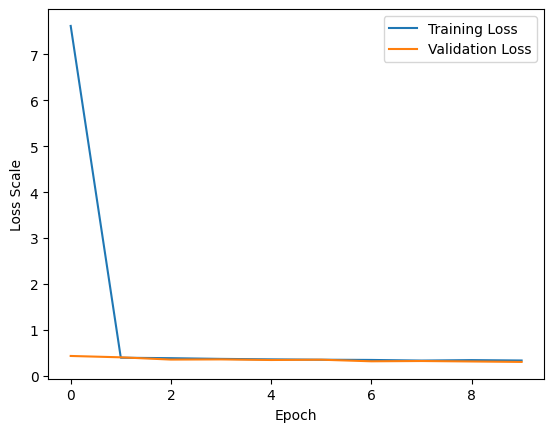

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss Scale')
plt.legend()
plt.show()